# DER Data Cleaning
This notebook will clean and process DER output ROOT files into a form manageable by a CVAE.  Pandas DataFrames are used as the main data structures.  The above cell can be referenced if this notebook does not run on your machine as a list of packages and versions that allow this notebook to run properly.

In [1]:
# !pip install seaborn uproot awkward-pandas

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import array
import time

start = time.time()

#set file limit and entries limit, set to >1000000 for full dataset
file_limit = 5
n_entries = 100000000

#make plot directory if it doesn't already exist
!mkdir -p plots/{str(file_limit)+'_files'}

#load file list
# der_dir = '/global/cfs/cdirs/lz/users/cobrien/cphy_project/files/'
der_dir = 'input_data/'
# file_list = 'filelist_reverse'
file_list = 'filelist_full'
f = open(file_list)
files = f.readlines()

#init DFs, file limit and run counters
df_pmt_temp = pd.DataFrame(columns=['run'])
df_wave_temp = pd.DataFrame(columns=['run'])
df_data = pd.DataFrame(columns=['run'])
df_wave = pd.DataFrame(columns=['run'])
df_pmt = pd.DataFrame(columns=['run'])
file_lim = 0
run = 0

#loop over files
for line in files:
    #comment out to run over full filelist
    if file_lim == file_limit:
        break
    file_lim+=1
    
    #open ROOT files via uproot
    file = der_dir+line
    root_file = uproot.open(file)

    #select trees
    dataevents = root_file['Data']
    eventevents = root_file['Event']
    mctruthevents = root_file['DetectorMCTruthTree']['DetectorMCTruthEvent']

    #select branches of trees
    databranches = ['evt', 'channel', 'hit', 'startTime', 'nSamples', 'zData']
    eventbranches = ['globalEvt', 'sumPODlength']
    mctruthbranches = ['pulses.iPMTIndices', 'pulses.iPMTHits']#, 'pulses.iPulseIdentifier']

    #create dataframes of trees/branches
    df_data = dataevents.arrays(databranches, library='pd', entry_stop=n_entries)
    df_event = eventevents.arrays(eventbranches, library='pd', entry_stop=n_entries)
    df_mctruth = mctruthevents.arrays(mctruthbranches, library='pd', entry_stop=n_entries)
    
    #combine event (globalEvt branch) and mctruth (PMTinfo) DFs, rename columns,
    #drop rows containing NaNs, add run value for this run (file #), and create full PMT info DF
    df_pmt_temp = pd.concat([df_event, df_mctruth], axis=1)
    df_wave_temp = df_data
    df_pmt_temp = df_pmt_temp.rename({'pulses.iPMTIndices':'PMTIndices', 'pulses.iPMTHits':'PMTHits', 'globalEvt':'evt'}, axis=1)
    df_wave_temp = df_wave_temp.rename({'zData':'ADCC'}, axis=1)
    df_pmt_temp['run'] = run
    df_wave_temp['run'] = run
    run+=1
    df_pmt = pd.concat([df_pmt, df_pmt_temp], axis=0)
    df_wave = pd.concat([df_wave, df_wave_temp], axis=0)

#set relevant column values to int
df_pmt = df_pmt.astype({'evt':int,
                          'run':int})
df_wave = df_wave.astype({'evt':int,
                          'run':int,
                          'channel':int,
                          'nSamples':int})

#split df_wave into lower and upper dfs
df_wave_lower = df_wave.loc[df_wave['channel'] < 1000].reset_index(drop=True)

#uncomment to explore other dataset
# df_wave_upper = df_wave.loc[df_wave['channel'] >= 1000].reset_index(drop=True)
# df_wave_upper['channel'] = df_wave_upper['channel'] - 1000     #reset channel #s in upper df to true values

#show dataframe
df_wave_lower

,run,evt,channel,hit,startTime,nSamples,ADCC
0,0,0,805,0.0,9.071200e+04,83,"[7372, 7370, 7369, 7376, 7376, 7372, 7369, 736..."
1,0,0,807,0.0,9.070900e+04,81,"[7376, 7367, 7367, 7369, 7371, 7372, 7373, 738..."
2,0,0,808,0.0,9.070500e+04,90,"[7366, 7377, 7371, 7377, 7368, 7364, 7368, 737..."
3,0,0,809,0.0,9.070800e+04,81,"[7374, 7368, 7378, 7373, 7379, 7361, 7371, 737..."
4,0,0,810,0.0,9.071000e+04,84,"[7370, 7368, 7371, 7370, 7372, 7371, 7377, 736..."
...,...,...,...,...,...,...,...
47441,4,94,915,0.0,1.069707e+10,105,"[7375, 7378, 7372, 7369, 7364, 7373, 7370, 737..."
47442,4,94,916,0.0,1.069707e+10,94,"[7375, 7378, 7375, 7375, 7372, 7372, 7371, 737..."
47443,4,94,917,0.0,1.069707e+10,106,"[7375, 7374, 7374, 7372, 7369, 7371, 7376, 737..."
47444,4,94,918,0.0,1.069707e+10,102,"[7368, 7375, 7373, 7372, 7374, 7378, 7379, 736..."


In [3]:
#check data types of dataframe
print(df_wave_lower.dtypes)

run            int64
evt            int64
channel        int64
hit          float64
startTime    float64
nSamples       int64
ADCC         awkward
dtype: object


In [4]:
#init full counts df
df_counts_sum = pd.DataFrame()
#find PMTs within a single event that occur multiple times
#loop over files
for i in range(0, file_limit):
    #loop over total events in file
    for j in range(0, df_wave_lower['evt'].max()+1):
        #slice series of matching PMT rows, turn to frame, create sum over all events and files
        s_count = df_wave_lower['channel'].loc[(df_wave_lower['run']==i) & (df_wave_lower['evt']==j)].value_counts(sort=False)
        df_counts = s_count.to_frame()
        df_counts['run'] = i
        df_counts['evt'] = j
        df_counts.reset_index(inplace=True)
        # df_counts = df_counts.rename(columns = {'channel':'channelCount'})
        df_counts = df_counts.rename(columns = {'index':'channel'})
        df_counts_sum = pd.concat([df_counts_sum, df_counts])

#fill main df with channel counts found above
#loop over files
for i in range(0, file_limit):
    #loop over events in file
    for j in range(0, df_wave_lower['evt'].loc[(df_wave_lower['run']==i)].max()+1):
        #loop over all PMTs in event
        for k in range(0, len(df_wave_lower.loc[(df_wave_lower['run']==i) & (df_wave_lower['evt']==j)])):
            #find channel number of current row, grab channel count, insert into main df
            chan = df_wave_lower.loc[(df_wave_lower['run']==i) & (df_wave_lower['evt']==j), 'channel'].iloc[k]
            chan_count = df_counts_sum.loc[(df_counts_sum['run']==i) & (df_counts_sum['evt']==j) & (df_counts_sum['channel']==chan), 'count'].values[0]
            df_wave_lower.loc[(df_wave_lower['run']==i) & (df_wave_lower['evt']==j) & (df_wave_lower['channel']==chan), 'count'] = chan_count
 
#drop all PMT channels occuring multiple times in single events, reset index, and show df
df_wave_lower = df_wave_lower[df_wave_lower['count'] == 1]
df_wave_lower.reset_index(inplace=True, drop=True)
df_wave_lower

,run,evt,channel,hit,startTime,nSamples,ADCC,count
0,0,0,805,0.0,9.071200e+04,83,"[7372, 7370, 7369, 7376, 7376, 7372, 7369, 736...",1.0
1,0,0,807,0.0,9.070900e+04,81,"[7376, 7367, 7367, 7369, 7371, 7372, 7373, 738...",1.0
2,0,0,808,0.0,9.070500e+04,90,"[7366, 7377, 7371, 7377, 7368, 7364, 7368, 737...",1.0
3,0,0,809,0.0,9.070800e+04,81,"[7374, 7368, 7378, 7373, 7379, 7361, 7371, 737...",1.0
4,0,0,810,0.0,9.071000e+04,84,"[7370, 7368, 7371, 7370, 7372, 7371, 7377, 736...",1.0
...,...,...,...,...,...,...,...,...
30539,4,94,915,0.0,1.069707e+10,105,"[7375, 7378, 7372, 7369, 7364, 7373, 7370, 737...",1.0
30540,4,94,916,0.0,1.069707e+10,94,"[7375, 7378, 7375, 7375, 7372, 7372, 7371, 737...",1.0
30541,4,94,917,0.0,1.069707e+10,106,"[7375, 7374, 7374, 7372, 7369, 7371, 7376, 737...",1.0
30542,4,94,918,0.0,1.069707e+10,102,"[7368, 7375, 7373, 7372, 7374, 7378, 7379, 736...",1.0


In [5]:
#find # of total photons incident on each PMT over an event
def fillPhotonHits(df_wave, df_pmt, file_limit):
    #loop over files
    for run in range(0,file_limit):
        #slice hits and indices from main df
        inds_np = df_pmt.loc[df_pmt['run']==run]['PMTIndices'].to_numpy()
        hits_np = df_pmt.loc[df_pmt['run']==run]['PMTHits'].to_numpy()
        #init dictionary for hits
        hits_dict_arr = []
        #loop over events in file
        for event in range(0,len(inds_np)):
            hits_sum = 0
            hits_dict = {}
            #loop over time steps in event
            for step in range(0,len(inds_np[event])):
                #loop over PMTs within one time_step
                for index in range(0,len(inds_np[event][step])):
                    current_index = inds_np[event][step][index]
                    current_hits = hits_np[event][step][index]
                    #if current index exists in hits_dict then add current_hits to it
                    #if not, add PMT index as key with current_hits as value
                    hits_sum += current_hits
                    if current_index in hits_dict:
                        hits_dict[current_index] += current_hits
                    else:
                        hits_dict.update({current_index : current_hits})
            #sort keys ascending order, add current event dict to hits dict array
            keys = list(hits_dict.keys())
            keys.sort()
            hits_dict = {i: hits_dict[i] for i in keys}
            hits_dict_arr.append(hits_dict)
        #loop over events in hits dict array
        for evt in range(0,len(hits_dict_arr)):
            #loop over channels in event
            for channel in hits_dict_arr[evt]:
                #grab photon_sum from dict for current run, evt, channel and insert into df
                photon_sum = hits_dict_arr[evt][channel]
                df_wave.loc[(df_wave['run']==run) & (df_wave['evt']==evt) & (df_wave['channel']==channel), 'channelPhotonSum'] = photon_sum
    return(df_wave)

#expand ADCC array into columns 'sample##3#' 
def adccExpand(df_filled, df_pmt, df_wave):
    #init arrays
    adcc_arr = []
    col_name_arr = []
    #set sample limit (majority of waveforms within ~200 samples)
    sample_limit = 200
    #loop over rows
    for i in range(0,len(df_wave_lower)):
        #call row by index, grab only ADCC column
        adcc_row = df_wave_lower.iloc[i]['ADCC']
        #trim to sample limit if greater
        if len(adcc_row) > sample_limit:
            adcc_row_full = adcc_row[0:sample_limit]
        else:
            #init array of base DER response of length defined by sample_limit long and fill with adcc_row
            der_base = 7389
            adcc_row_full = np.full(sample_limit, der_base)
            adcc_row_full[:len(adcc_row)] = adcc_row
        #fill adcc_row array
        adcc_arr.append(adcc_row_full)  
    #loop over range of samples
    for m in range(0, sample_limit):
        #create column name up to hundreds place
        col_name_arr.append('sample'+str(m).zfill(3))
    #populate new expanded df
    df_expanded = pd.DataFrame(data=adcc_arr, columns=col_name_arr)
    
    return(df_expanded)

#call fillPhotonHits and adccExpand functions to concat into complete df
def concatFilledExpanded(df_wave, df_pmt, file_limit):
    df_wave_filled = fillPhotonHits(df_wave, df_pmt, file_limit)
    df_wave_expanded = adccExpand(df_wave_filled, df_pmt, df_wave)
    #drop ADCC column, should always exist
    if 'ADCC' in df_wave_filled:
        df_wave_filled = df_wave_filled.drop(['ADCC'], axis=1)
    #concat the dfs
    df_wave_filled_expanded = pd.concat([df_wave_filled, df_wave_expanded], axis=1)
    return(df_wave_filled_expanded)

#call concat funciton to finish processing main df, uncomment upper if using
df_wave_lower_filled_expanded = concatFilledExpanded(df_wave_lower, df_pmt, file_limit)
# df_wave_upper_filled_expanded = concatFilledExpanded(df_wave_upper, df_pmt, file_limit)

#print time finished
end = time.time()
print('Dataframe population runtime: ', end-start)

#show fully processed df
df_wave_lower_filled_expanded

/tmp/ipykernel_11001/1698939082.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wave.loc[(df_wave['run']==run) & (df_wave['evt']==evt) & (df_wave['channel']==channel), 'channelPhotonSum'] = photon_sum


Dataframe population runtime:  196.17657828330994


,run,evt,channel,hit,startTime,nSamples,count,channelPhotonSum,sample000,sample001,...,sample190,sample191,sample192,sample193,sample194,sample195,sample196,sample197,sample198,sample199
0,0,0,805,0.0,9.071200e+04,83,1.0,1.0,7372,7370,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
1,0,0,807,0.0,9.070900e+04,81,1.0,1.0,7376,7367,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
2,0,0,808,0.0,9.070500e+04,90,1.0,4.0,7366,7377,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
3,0,0,809,0.0,9.070800e+04,81,1.0,1.0,7374,7368,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
4,0,0,810,0.0,9.071000e+04,84,1.0,3.0,7370,7368,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30539,4,94,915,0.0,1.069707e+10,105,1.0,20.0,7375,7378,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
30540,4,94,916,0.0,1.069707e+10,94,1.0,16.0,7375,7378,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
30541,4,94,917,0.0,1.069707e+10,106,1.0,8.0,7375,7374,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
30542,4,94,918,0.0,1.069707e+10,102,1.0,11.0,7368,7375,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389


In [6]:
#show details for trimmed df
df_wave_lower_filled_expanded.describe()

,run,evt,channel,hit,startTime,nSamples,count,channelPhotonSum,sample000,sample001,...,sample190,sample191,sample192,sample193,sample194,sample195,sample196,sample197,sample198,sample199
count,30544.000000,30544.000000,30544.000000,30544.0,3.054400e+04,30544.000000,30544.0,30140.000000,30544.000000,30544.000000,...,30544.000000,30544.000000,30544.000000,30544.000000,30544.000000,30544.000000,30544.000000,30544.000000,30544.000000,30544.000000
mean,2.821569,43.416907,838.746595,0.0,4.420983e+09,98.112297,1.0,39.775116,7372.292529,7372.368190,...,7349.306214,7349.659704,7349.908427,7350.111708,7350.065676,7349.850478,7349.699712,7349.722368,7349.950629,7350.234580
std,0.994098,28.351474,109.991476,0.0,2.953507e+09,38.246837,0.0,709.765309,3.501373,3.538801,...,475.876944,471.809600,469.542199,468.173435,468.958986,471.464629,473.306273,472.921908,470.054940,467.413654
min,0.000000,0.000000,0.000000,0.0,9.070400e+04,77.000000,1.0,1.000000,7354.000000,7356.000000,...,-8192.000000,-8192.000000,-8192.000000,-8192.000000,-8192.000000,-8192.000000,-8192.000000,-8192.000000,-8192.000000,-8192.000000
25%,2.000000,17.000000,825.000000,0.0,1.769623e+09,87.000000,1.0,3.000000,7370.000000,7370.000000,...,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000
50%,3.000000,43.000000,856.000000,0.0,4.233911e+09,93.000000,1.0,6.000000,7372.000000,7372.000000,...,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000
75%,4.000000,68.000000,887.000000,0.0,6.830576e+09,99.000000,1.0,10.000000,7375.000000,7375.000000,...,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000
max,4.000000,94.000000,919.000000,0.0,1.069707e+10,612.000000,1.0,93526.000000,7388.000000,7386.000000,...,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000


<Axes: title={'center': 'Photons Incident On PMTs'}, xlabel='PMT Channel', ylabel='Photon Hits'>

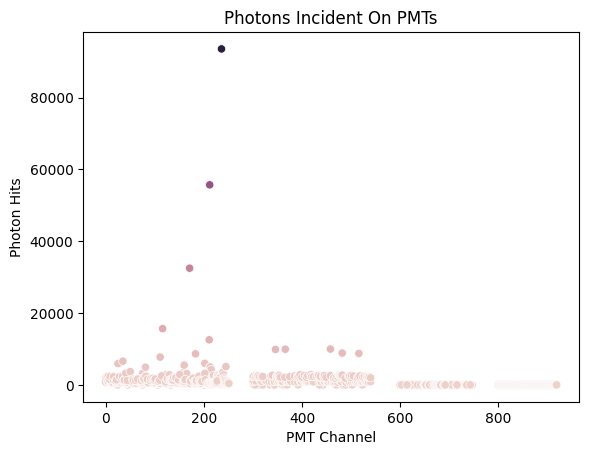

In [7]:
#plot photon hits to check for outliers
plot = sns.scatterplot(data=df_wave_lower_filled_expanded, 
                      x='channel', y='channelPhotonSum',
                      hue='channelPhotonSum', legend=False)
plot.set(xlabel='PMT Channel', ylabel='Photon Hits', title='Photons Incident On PMTs')
plot

<Axes: title={'center': 'Photons Incident On PMTs'}, xlabel='PMT Channel', ylabel='Photon Hits'>

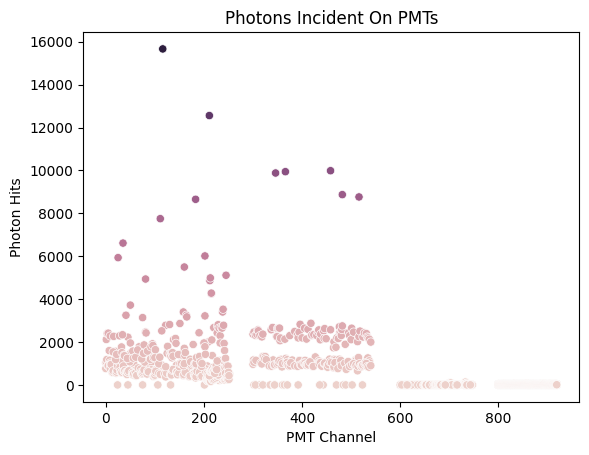

In [8]:
#drop outliers and replot if needed
cut_value = 20000    #set based on prior plot
df_wave_lower_filled_expanded_cut = df_wave_lower_filled_expanded[df_wave_lower_filled_expanded['channelPhotonSum'] < cut_value]
plot = sns.scatterplot(data=df_wave_lower_filled_expanded_cut,
                      x='channel', y='channelPhotonSum',
                      hue='channelPhotonSum', legend=False)
plot.set(xlabel='PMT Channel', ylabel='Photon Hits', title='Photons Incident On PMTs')
plot

In [9]:
#create dfs for pmt 800 and pmt 900
df_wave_pmt800_filled_expanded = df_wave_lower_filled_expanded.loc[df_wave_lower_filled_expanded['channel']==800]
df_wave_pmt900_filled_expanded = df_wave_lower_filled_expanded.loc[df_wave_lower_filled_expanded['channel']==900]

In [10]:
#show df for pmt 800
df_wave_pmt800_filled_expanded

,run,evt,channel,hit,startTime,nSamples,count,channelPhotonSum,sample000,sample001,...,sample190,sample191,sample192,sample193,sample194,sample195,sample196,sample197,sample198,sample199
77,0,1,800,0.0,1.515198e+07,94,1.0,2.0,7376,7372,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
192,0,2,800,0.0,2.712405e+08,104,1.0,21.0,7372,7373,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
310,0,3,800,0.0,4.966643e+08,114,1.0,16.0,7371,7373,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
424,0,4,800,0.0,7.697597e+08,96,1.0,6.0,7367,7373,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
638,0,6,800,0.0,1.094312e+09,96,1.0,4.0,7374,7374,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29961,4,89,800,0.0,9.959707e+09,95,1.0,9.0,7368,7367,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
30083,4,91,800,0.0,1.035465e+10,90,1.0,3.0,7373,7372,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
30215,4,92,800,0.0,1.037607e+10,87,1.0,4.0,7377,7376,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
30306,4,93,800,0.0,1.044898e+10,100,1.0,14.0,7373,7378,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389


In [11]:
#show df for pmt 900
df_wave_pmt900_filled_expanded

,run,evt,channel,hit,startTime,nSamples,count,channelPhotonSum,sample000,sample001,...,sample190,sample191,sample192,sample193,sample194,sample195,sample196,sample197,sample198,sample199
173,0,1,900,0.0,1.515198e+07,91,1.0,4.0,7373,7363,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
290,0,2,900,0.0,2.712405e+08,96,1.0,8.0,7370,7368,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
405,0,3,900,0.0,4.966643e+08,88,1.0,4.0,7370,7367,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
834,0,7,900,0.0,1.473097e+09,106,1.0,15.0,7379,7377,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
949,0,8,900,0.0,1.769623e+09,98,1.0,6.0,7373,7370,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30059,4,89,900,0.0,9.959707e+09,99,1.0,9.0,7374,7375,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
30181,4,91,900,0.0,1.035465e+10,98,1.0,5.0,7376,7368,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
30288,4,92,900,0.0,1.037607e+10,82,1.0,4.0,7376,7373,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389
30406,4,93,900,0.0,1.044898e+10,93,1.0,10.0,7373,7378,...,7389,7389,7389,7389,7389,7389,7389,7389,7389,7389


In [12]:
#save main, processed df to file
df_wave_lower_filled_expanded.to_csv('data_clean/lower_dataFrame_'+str(file_limit)+'_files.csv', sep=',', encoding='utf-8', header='true')
#uncomment if using secondary dataset
# df_wave_upper_filled_expanded.to_csv('data_clean/upper_dataFrame_'+str(file_limit)+'_files.csv', sep=',', encoding='utf-8', header='true')

In [13]:
#save dfs for pmts 800 and 900 to file
df_wave_pmt800_filled_expanded.to_csv('data_clean/pmt800_dataFrame_'+str(file_limit)+'_files.csv', sep=',', encoding='utf-8', header='true')
df_wave_pmt900_filled_expanded.to_csv('data_clean/pmt900_dataFrame_'+str(file_limit)+'_files.csv', sep=',', encoding='utf-8', header='true')

<Axes: title={'center': 'DER Response for All PMTs'}, xlabel='Sample', ylabel='ADC Count'>

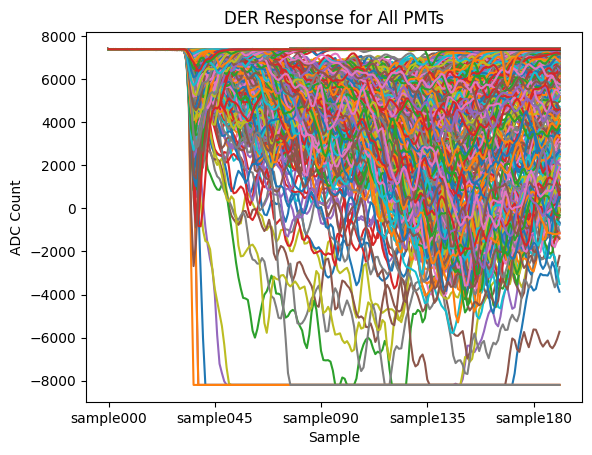

In [14]:
#the following cells generate and save plots of DER response 
#and incident photon count for various slices of PMTs
plot = df_wave_lower_filled_expanded.iloc[:,8:200].T.plot(title='DER Response for All PMTs', 
                                                    xlabel='Sample', ylabel='ADC Count', 
                                                    xticks=[0,45,90,135,180],
                                                    legend=False)
fig = plot.get_figure()
fig.savefig('plots/'+str(file_limit)+'_files/der_plot_pmtAll_'+str(file_limit)+'_files.png')
plot

<Axes: title={'center': 'DER Response for PMT 800'}, xlabel='Sample', ylabel='ADC Count'>

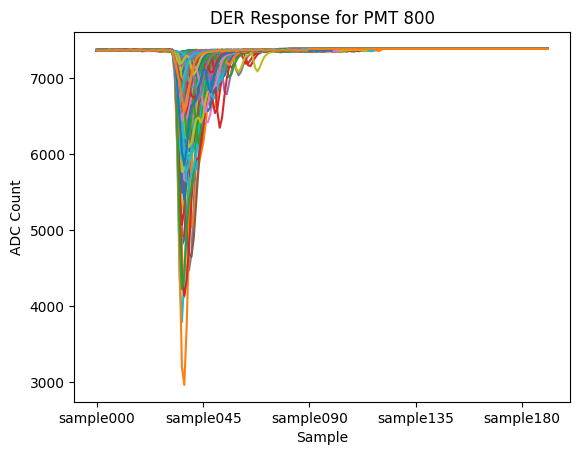

In [15]:
plot = df_wave_pmt800_filled_expanded.iloc[:,8:200].T.plot(title='DER Response for PMT 800', 
                                                    xlabel='Sample', ylabel='ADC Count', 
                                                    xticks=[0,45,90,135,180],
                                                    legend=False)
fig = plot.get_figure()
fig.savefig('plots/'+str(file_limit)+'_files/der_plot_pmt800_'+str(file_limit)+'_files.png')
plot

<Axes: title={'center': 'DER Response for PMT 800'}, xlabel='Sample', ylabel='ADC Count'>

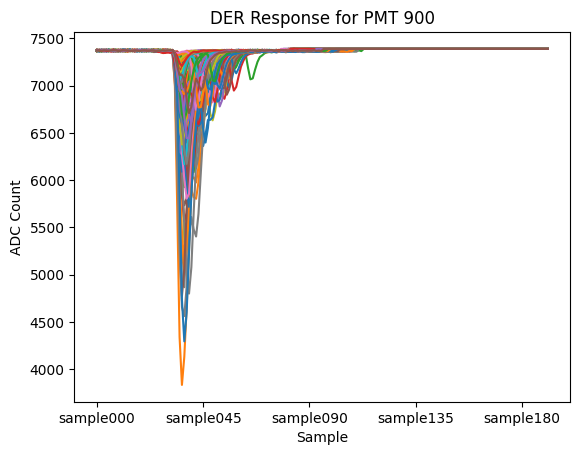

In [16]:
df_wave_pmt900_filled_expanded.iloc[:,8:200].T.plot(title='DER Response for PMT 900', 
                                                    xlabel='Sample', ylabel='ADC Count', 
                                                    xticks=[0,45,90,135,180],
                                                    legend=False)
fig = plot.get_figure()
fig.savefig('plots/'+str(file_limit)+'_files/der_plot_pmt900_'+str(file_limit)+'_files.png')
plot

<Axes: title={'center': 'DER Response for PMTs 0-200'}, xlabel='Sample', ylabel='ADC Count'>

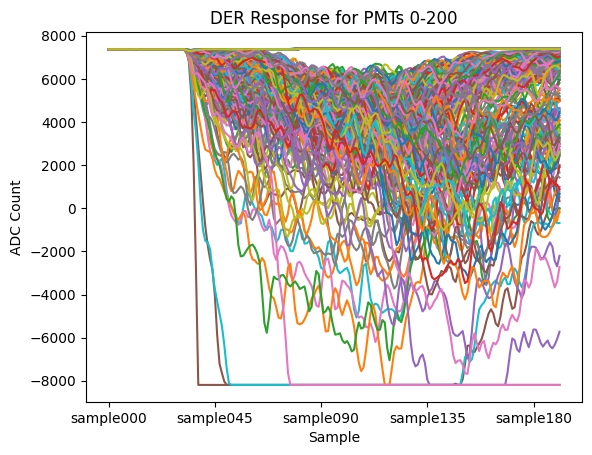

In [17]:
df_wave_pmtSub200_filled_expanded = df_wave_lower_filled_expanded.loc[df_wave_lower_filled_expanded['channel']<=200]
plot = df_wave_pmtSub200_filled_expanded.iloc[:,8:200].T.plot(title='DER Response for PMTs 0-200', 
                                                    xlabel='Sample', ylabel='ADC Count', 
                                                    xticks=[0,45,90,135,180],
                                                    legend=False)
fig = plot.get_figure()
fig.savefig('plots/'+str(file_limit)+'_files/der_plot_pmtSub200_'+str(file_limit)+'_files.png')
plot

<Axes: title={'center': 'DER Response for PMTs 800-919'}, xlabel='Sample', ylabel='ADC Count'>

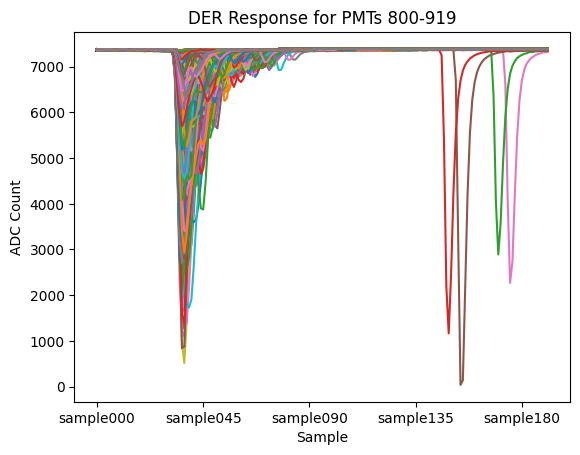

In [18]:
df_wave_pmtPast800_filled_expanded = df_wave_lower_filled_expanded.loc[df_wave_lower_filled_expanded['channel']>=800]
plot = df_wave_pmtPast800_filled_expanded.iloc[:,8:200].T.plot(title='DER Response for PMTs 800-919', 
                                                    xlabel='Sample', ylabel='ADC Count', 
                                                    xticks=[0,45,90,135,180],
                                                    legend=False)
fig = plot.get_figure()
fig.savefig('plots/'+str(file_limit)+'_files/der_plot_pmtPast800_'+str(file_limit)+'_files.png')
plot

<Axes: title={'center': 'Photons Incident On All PMTs'}, xlabel='PMT Channel', ylabel='Photon Hits'>

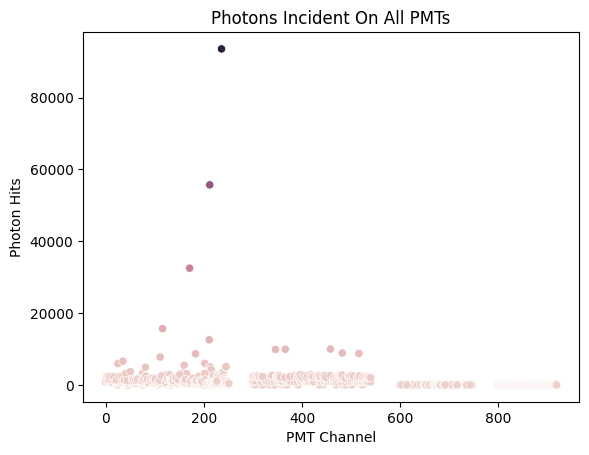

In [19]:
plot = sns.scatterplot(data=df_wave_lower_filled_expanded,
                      x='channel', y='channelPhotonSum',
                      hue='channelPhotonSum', legend=False)
plot.set(xlabel='PMT Channel', ylabel='Photon Hits', title='Photons Incident On All PMTs')
fig = plot.get_figure()
fig.savefig('plots/'+str(file_limit)+'_files/pmt_hit_plot_pmtAll_'+str(file_limit)+'_files.png')
plot

<Axes: title={'center': 'Photons Incident On PMT 900'}, xlabel='Photon Hits', ylabel='Count'>

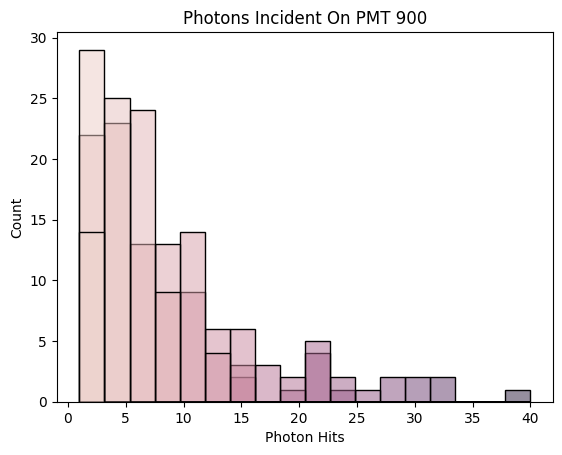

In [20]:
plot = sns.histplot(data=df_wave_pmt800_filled_expanded,
                    x='channelPhotonSum',
                    hue='channelPhotonSum', legend=False)
plot.set(xlabel='Photon Hits', title='Photons Incident On PMT 900')
fig = plot.get_figure()
fig.savefig('plots/'+str(file_limit)+'_files/pmt_hit_plot_pmt800_'+str(file_limit)+'_files.png')
plot

<Axes: title={'center': 'Photons Incident On PMT 900'}, xlabel='Photon Hits', ylabel='Count'>

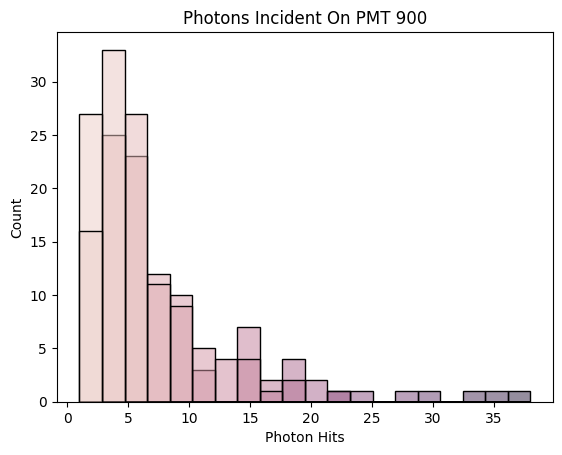

In [21]:
plot = sns.histplot(data=df_wave_pmt900_filled_expanded,
                    x='channelPhotonSum',
                    hue='channelPhotonSum', legend=False)
plot.set(xlabel='Photon Hits', title='Photons Incident On PMT 900')
fig = plot.get_figure()
fig.savefig('plots/'+str(file_limit)+'_files/pmt_hit_plot_pmt900_'+str(file_limit)+'_files.png')
plot

<Axes: title={'center': 'Photons Incident On PMTs 0-200'}, xlabel='PMT Channel', ylabel='Photon Hits'>

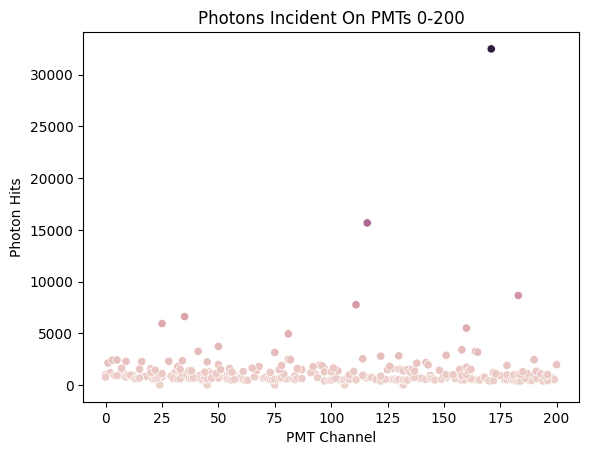

In [22]:
plot = sns.scatterplot(data=df_wave_pmtSub200_filled_expanded,
                      x='channel', y='channelPhotonSum',
                      hue='channelPhotonSum', legend=False)
plot.set(xlabel='PMT Channel', ylabel='Photon Hits', title='Photons Incident On PMTs 0-200')
fig = plot.get_figure()
fig.savefig('plots/'+str(file_limit)+'_files/pmt_hit_plot_pmtSub200_'+str(file_limit)+'_files.png')
plot

<Axes: title={'center': 'Photons Incident On PMTs 0-500'}, xlabel='PMT Channel', ylabel='Photon Hits'>

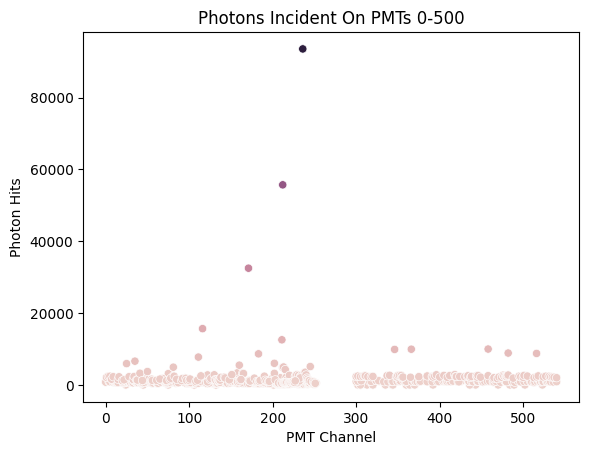

In [23]:
df_wave_pmtSub500_filled_expanded = df_wave_lower_filled_expanded.loc[df_wave_lower_filled_expanded['channel']<=550]
plot = sns.scatterplot(data=df_wave_pmtSub500_filled_expanded,
                      x='channel', y='channelPhotonSum',
                      hue='channelPhotonSum', legend=False)
plot.set(xlabel='PMT Channel', ylabel='Photon Hits', title='Photons Incident On PMTs 0-500')
fig = plot.get_figure()
fig.savefig('plots/'+str(file_limit)+'_files/pmt_hit_plot_pmtSub500_'+str(file_limit)+'_files.png')
plot

<Axes: title={'center': 'Photons Incident On PMTs 800-919'}, xlabel='PMT Channel', ylabel='Photon Hits'>

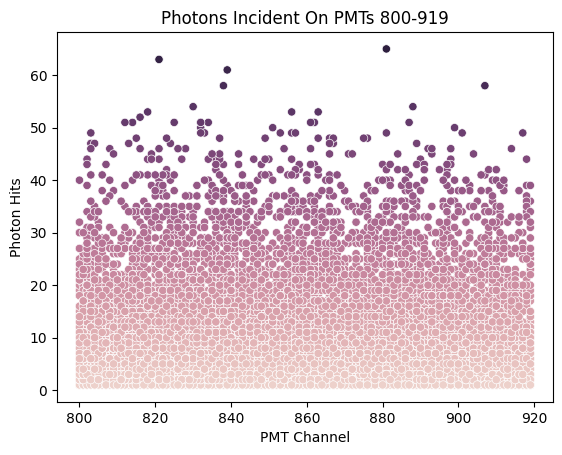

In [24]:
plot = sns.scatterplot(data=df_wave_pmtPast800_filled_expanded,
                      x='channel', y='channelPhotonSum',
                      hue='channelPhotonSum', legend=False)
plot.set(xlabel='PMT Channel', ylabel='Photon Hits', title='Photons Incident On PMTs 800-919')
fig = plot.get_figure()
fig.savefig('plots/'+str(file_limit)+'_files/pmt_hit_plot_pmtPast800_'+str(file_limit)+'_files.png')
plot